**Author:** [Riccardo Guidotti](http://kdd.isti.cnr.it/people/riccardo-guidotti)  
**Python version:**  3.x

In [2]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
sys.path.append('./lore/')

In [4]:
from util import record2str, neuclidean
from datamanager import prepare_adult_dataset, prepare_dataset

# Data Preparation

In [5]:
class_name = 'titleType'
df = pd.read_csv('imbd_cleaned.csv')

# Mappa di raggruppamento
category_mapping = {
    'movie': 'Film',
    'tvMovie': 'Film',
    'short': 'Shorts',
    'tvShort': 'Shorts',
    'tvSeries': 'Serie TV',
    'tvMiniSeries': 'Serie TV',
    'tvEpisode': 'Serie TV',
    'tvSpecial': 'Speciale TV',
    'video': 'Video',
    'videoGame': 'Videogame'
}

# Applicare la mappa al dataframe
df['titleType'] = df['titleType'].map(category_mapping)

df.head()

,originalTitle,rating,startYear,runtimeMinutes,awardWins,numVotes,totalImages,totalVideos,totalCredits,criticReviewsTotal,...,genres,castNumber,companiesNumber,averageRating,regions,externalLinks,writerCredits,directorsCredits,soundMixes,quotesTotal
0,Carmencita,"(5, 6]",1894,1.0,0.000000,7.644919,1.098612,0.0,4,1.386294,...,"Documentary,Short",0.693147,1.386294,5.7,"['\\N', 'DE', 'US', 'HU', 'GR', 'RU', 'UA', 'JP']",2.302585,0.0,0.693147,['silent'],0.0
1,Un bon bock,"(5, 6]",1892,12.0,0.000000,5.214936,1.098612,0.0,2,0.000000,...,"Animation,Short",0.000000,0.000000,5.4,"['\\N', 'HU', 'DE', 'FR', 'RO', 'RU', 'JP']",1.386294,0.0,0.693147,['silent'],0.0
2,Chinese Opium Den,"(4, 5]",1894,1.0,0.000000,5.278115,0.693147,0.0,1,0.000000,...,Short,0.000000,0.693147,5.0,"['\\N', 'US', 'DE', 'PT', 'HU', 'RU']",1.609438,0.0,0.693147,['silent'],0.0
3,Edison Kinetoscopic Record of a Sneeze,"(5, 6]",1894,1.0,0.693147,7.713338,1.386294,0.0,4,1.098612,...,"Documentary,Short",0.693147,1.945910,5.4,"['\\N', 'UA', 'JP', 'HU', 'US', 'DE', 'RU']",1.945910,0.0,0.693147,['silent'],0.0
4,Autour d'une cabine,"(6, 7]",1894,2.0,0.000000,7.107425,2.772589,0.0,1,0.000000,...,"Animation,Short",0.000000,0.000000,6.1,"['\\N', 'ES', 'US', 'FR', 'HU', 'RU', 'UA']",1.386294,0.0,0.693147,['silent'],0.0


In [6]:
#FUNZIONE PREPARE_DATASET DI GUIDOTTI RISCRITTA (e modificata)

from collections import defaultdict

# --- 1. CLASS NAME ---
class_name = 'titleType'  # tua variabile target

# --- 2. NUMERIC COLUMNS ---
numeric_columns = list(df._get_numeric_data().columns)

# --- 3. BACKUP DATAFRAME (RDF) ---
rdf = df.copy()

# Questo pezzo di codice elimina le feature categoriche con più di 20 classi,
# così da non creare problemi al one-hot encoding generale che viene fatto nel passaggio 4
# Soglia massima di classi per le feature categoriche
max_categories = 20

categorical_cols = df.select_dtypes(include=['object', 'category']).columns  ## Identifica le colonne categoriche (oggetti o stringhe)

high_cardinality_cols = [col for col in categorical_cols if df[col].nunique() > max_categories]  ## Trova colonne con troppe classi

df_filtered = df.drop(columns=high_cardinality_cols)  ## Elimina queste colonne dal DataFrame

print("Colonne rimosse per alta cardinalità:")
for col in high_cardinality_cols:
    print(f"{col}: {df[col].nunique()} categorie")


# --- 4. ONE-HOT ENCODING (esclude solo la target) ---
# ATTENZIONE: fa il one-hot encoding su tutte le colonne del DataFrame df tranne la target
# Se una colonna è numerica, rimane così com'è
# Se una colonna è categoriale, viene espansa in più colonne binarie, una per ogni categoria distinta.
dfX = pd.get_dummies(df_filtered[[c for c in df_filtered.columns if c != class_name]], prefix_sep='=')
class_name_map = {v: k for k, v in enumerate(sorted(df[class_name].unique()))}
dfY = df[class_name].map(class_name_map)

# df finale
df_encoded = pd.concat([dfX, dfY], axis=1)
feature_names = list(dfX.columns)
class_values = sorted(class_name_map)

# --- 5. REAL FEATURE NAMES ---
real_feature_names = [
    c for c in rdf.columns if c in numeric_columns and c != class_name
] + [
    c for c in rdf.columns if c not in numeric_columns and c != class_name
]

# --- 6. RIFILTRAGGIO RDF (solo colonne utili)
rdf = rdf[real_feature_names + [class_name]]

# --- 7. FEATURE MAP ---
features_map = defaultdict(dict)
i, j = 0, 0
while i < len(feature_names) and j < len(real_feature_names):
    if feature_names[i] == real_feature_names[j]:
        features_map[j][feature_names[i].replace('%s=' % real_feature_names[j], '')] = i
        i += 1
        j += 1
    elif feature_names[i].startswith(real_feature_names[j]):
        features_map[j][feature_names[i].replace('%s=' % real_feature_names[j], '')] = i
        i += 1
    else:
        j += 1


# https://chatgpt.com/share/6820ac60-f9b8-8012-83bb-2b54acb5966c

Colonne rimosse per alta cardinalità:
originalTitle: 132380 categorie
countryOfOrigin: 2574 categorie
genres: 1412 categorie
regions: 25302 categorie
soundMixes: 228 categorie


In [7]:
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, f1_score, classification_report

In [8]:
from sklearn.model_selection import train_test_split

test_size = 0.30
random_state = 0

# Ultima colonna del df_encoded è la variabile target mappata (dfY)
X = df_encoded[feature_names].values
y = df_encoded[class_name].values  # oppure: y = dfY.values

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=test_size,
    random_state=random_state,
    stratify=y
)

# Classification

In [9]:
from sklearn.ensemble import RandomForestClassifier

In [10]:
bb = RandomForestClassifier(n_estimators=20, random_state=42)
bb.fit(X_train, y_train)

RandomForestClassifier(n_estimators=20, random_state=42)

In [11]:
def bb_predict(X):
    return bb.predict(X)

def bb_predict_proba(X):
    return bb.predict_proba(X)

In [12]:
y_pred = bb_predict(X_test)

print('Accuracy %.3f' % accuracy_score(y_test, y_pred))

Accuracy 0.925


## Global

In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

In [14]:
y_pred_train = bb_predict(X_train)

In [15]:
explainer = DecisionTreeClassifier(max_depth=4)
explainer.fit(X_train, y_pred_train)

DecisionTreeClassifier(max_depth=4)

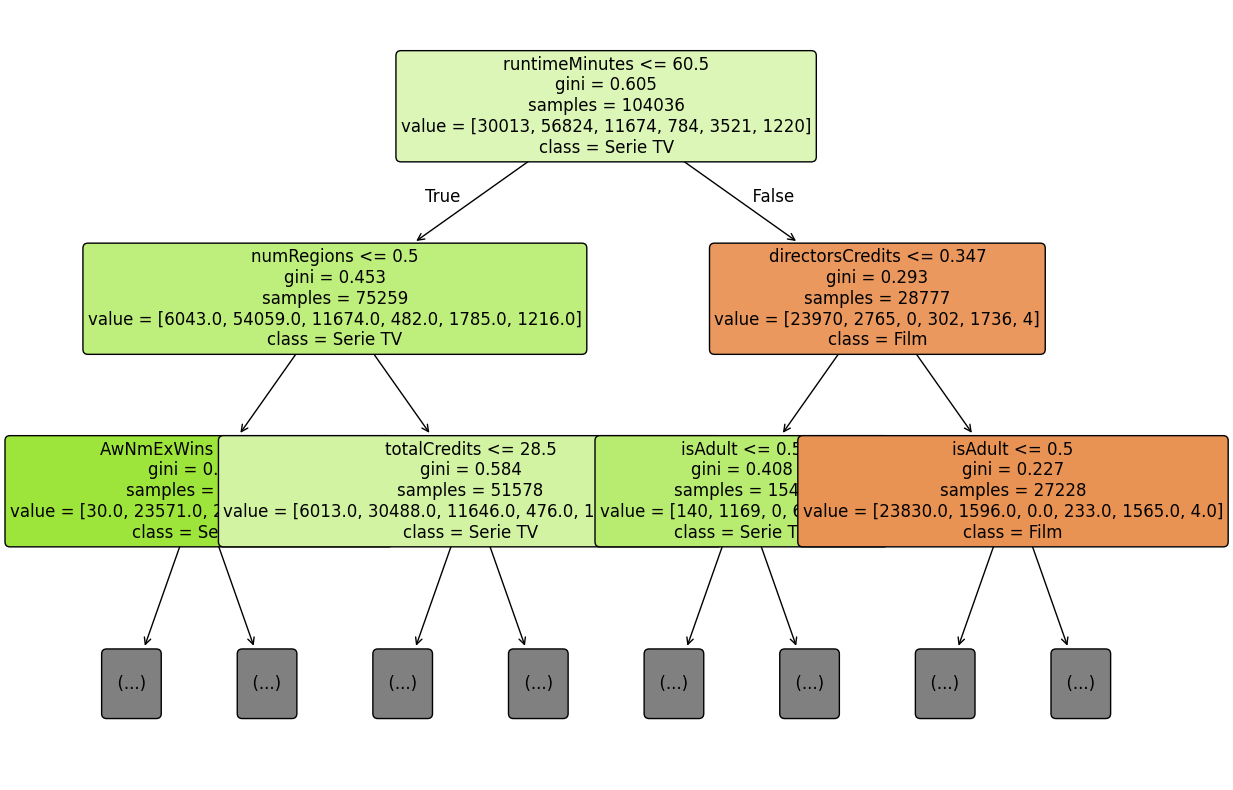

In [16]:
plt.figure(figsize=(14, 10))
plot_tree(explainer, 
          feature_names=feature_names, 
          class_names=list(class_name_map.keys()), 
          filled=True, 
          rounded=True,
          fontsize=12,
          max_depth=2)  
plt.show()

In [17]:
y_pred_explainer = explainer.predict(X_test)
y_pred_bb = bb.predict(X_test)

accuracy_score(y_pred_bb, y_pred_explainer) # fidelity

0.856037498878622

In [18]:
accuracy_score(y_test, y_pred_explainer)

0.8183143446667265

## Local

In [19]:
# RECORD A CASO CHE SPIEGA LIME LOCALMENTE (E ALTRI MODELLI LOCALI?)

i2e = 22
x = X_test[i2e]
x

array([1975, 25.0, 0.0, 4.59511985013459, 1.0986122886681098, 0.0, 45,
       0.0, 0.0, 0, 0, 1, 1.3862943611198906, 2.079441541679836,
       1.3862943611198906, 8.3, 0.0, 1.9459101490553128,
       0.6931471805599453, 0.0, False, False, False, False, False, False,
       False, False, True, False], dtype=object)

In [20]:
record2str(x, feature_names, numeric_columns)

'{ startYear = 1975, runtimeMinutes = 25.0, awardWins = 0.0, numVotes = 4.59511985013459, totalImages = 1.0986122886681098, totalVideos = 0.0, totalCredits = 45, criticReviewsTotal = 0.0, AwNmExWins = 0.0, canHaveEpisodes = 0, isAdult = 0, numRegions = 1, userReviewsTotal = 1.3862943611198906, castNumber = 2.079441541679836, companiesNumber = 1.3862943611198906, averageRating = 8.3, externalLinks = 0.0, writerCredits = 1.9459101490553128, directorsCredits = 0.6931471805599453, quotesTotal = 0.0, rating = (8, 9] }'

In [21]:
# PREDIZIONE DEL RANDOMFOREST PER IL NOSTRO RECORD SINGOLO CASUALE

bb_outcome = bb_predict(x.reshape(1, -1))[0]
bb_outcome_str = class_values[bb_outcome]

print('bb(x) = { %s }' % bb_outcome_str)
print('')

bb(x) = { Serie TV }



### LIME

In [24]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 1.2 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 3.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.5/313.5 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.7/225.7 kB 8.9 MB/s eta 0:00:00
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=acc1859914337a2f833c2971831f35854364227bb9d108c668193addaabbd6f4
  Stored in directory: /Users/riccardo/Library/Caches/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [22]:
from lime.lime_tabular import LimeTabularExplainer

In [23]:
lime_explainer = LimeTabularExplainer(
    X_train,
    feature_names=feature_names,
    class_names=[str(v) for v in class_values], 
    discretize_continuous=False
)

In [24]:
exp = lime_explainer.explain_instance(x, bb_predict_proba)

In [25]:
exp.local_exp

{1: [(np.int64(11), np.float64(-0.14040856840124227)),
  (np.int64(8), np.float64(-0.05213132454846643)),
  (np.int64(2), np.float64(-0.04594300380973257)),
  (np.int64(1), np.float64(-0.040061125378136636)),
  (np.int64(16), np.float64(-0.026921258071455935)),
  (np.int64(0), np.float64(0.023867474312494193)),
  (np.int64(15), np.float64(0.021126238954119594)),
  (np.int64(12), np.float64(-0.013486780731931575)),
  (np.int64(17), np.float64(0.011892822565626572)),
  (np.int64(28), np.float64(0.005902877547142065))]}

In [26]:
exp.show_in_notebook()

ImportError: cannot import name 'display' from 'IPython.core.display' (C:\Users\alban\AppData\Roaming\Python\Python313\site-packages\IPython\core\display.py)

In [27]:
html = exp.as_html()
with open("lime_explanation.html", "w", encoding="utf-8") as f:
    f.write(html)

### SHAP

In [31]:
!pip install shap

Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
     ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
     ------- -------------------------------- 0.5/2.6 MB 3.0 MB/s eta 0:00:01
     ----------- ---------------------------- 0.8/2.6 MB 2.6 MB/s eta 0:00:01
     ------------------- -------------------- 1.3/2.6 MB 2.0 MB/s eta 0:00:01
     ------------------------------- -------- 2.1/2.6 MB 2.3 MB/s eta 0:00:01
     ---------------------------------------- 2.6/2.6 MB 2.6 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for shap: filename=shap-0.47.2-cp313-cp313-w


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [28]:
import shap
shap.initjs()

In [34]:
import numpy as np

# Numero di istanze che vuoi spiegare (es. 1000)
n_sample = 1000

# Seleziona indici casuali dal tuo X_test
sample_indices = np.random.choice(X_test.shape[0], size=n_sample, replace=False)

# Crea il sottoinsieme
X_sample = X_test[sample_indices]

In [39]:
f = lambda x: bb_predict_proba(x)[:, 1]
background = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]
shap_explainer = shap.KernelExplainer(f, background)


In [40]:
shap_values = shap_explainer.shap_values(X_sample, nsamples=1000)

100%|██████████| 1000/1000 [06:44<00:00,  2.47it/s]


In [41]:
shap_values

array([[ 0.        ,  0.10814707,  0.01297035, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , -0.04989146,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , -0.0529295 , -0.07708093, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.01825405, -0.19716307,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.04035664,  0.05803243,  0.01726089, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , -0.10417646,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

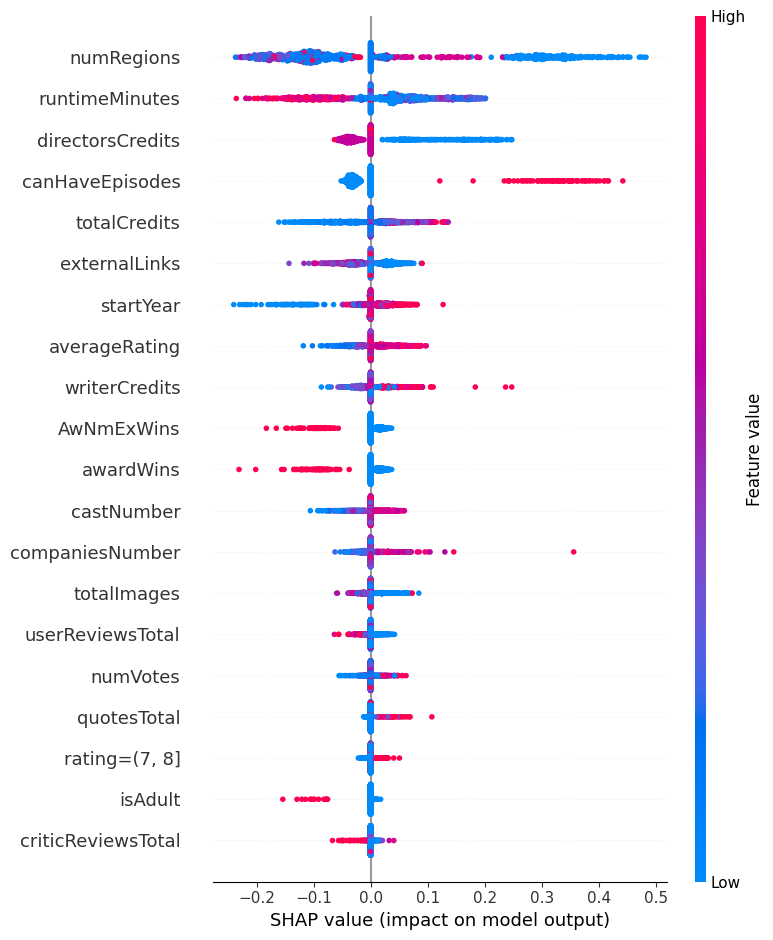

In [42]:
shap.summary_plot(shap_values, X_sample, feature_names=feature_names)

### LORE

In [35]:
# MI SONO FERMATO ALL IMPORTAZIONE DI LOREM
from lorem import LOREM

In [36]:
# Usa solo le colonne reali rimaste dopo il filtraggio delle alte cardinalità
real_feature_names_filtered = [
    f for f in real_feature_names 
    if f in df_filtered.columns
]

rdf_filtered = rdf[real_feature_names_filtered + [class_name]]

_, K, _, _ = train_test_split(
    rdf_filtered[real_feature_names_filtered].values,
    rdf_filtered[class_name].values,
    test_size=test_size,
    random_state=random_state,
    stratify=rdf_filtered[class_name].values
)


In [37]:
lore_explainer = LOREM(K, bb_predict, feature_names, class_name, class_values, numeric_columns, features_map,
                       neigh_type='geneticp', categorical_use_prob=True, continuous_fun_estimation=False, 
                       size=1000, ocr=0.1, random_state=42, ngen=10, bb_predict_proba=bb_predict_proba, 
                       verbose=True)

calculating feature values


In [38]:
exp = lore_explainer.explain_instance(x, samples=300, use_weights=True, metric=neuclidean)

generating neighborhood - geneticp
gen	nevals	avg     	min     	max     
0  	150   	0.496654	0.496654	0.496654


KeyError: '(9, 10]'

In [57]:
print(exp)

NameError: name 'exp' is not defined

In [36]:
x1 = x.copy()
x1[feature_names.index('total eve minutes')] = 170

print('x1 = %s' % record2str(x1, feature_names, numeric_columns))
print('')

x1 = { account length = 49, area code = 415, number vmail messages = 0, total day minutes = 266.3, total day calls = 90, total day charge = 45.27, total eve minutes = 170, total eve calls = 117, total eve charge = 17.66, total night minutes = 205.0, total night calls = 98, total night charge = 9.23, total intl minutes = 14.0, total intl calls = 2, total intl charge = 3.78, customer service calls = 2, state = UT, international plan = no, voice mail plan = no }



In [37]:
bb_outcome = bb_predict(x1.reshape(1, -1))[0]
bb_outcome_str = class_values[bb_outcome]

print('bb(x) = { %s }' % bb_outcome_str)
print('')

bb(x) = { False }



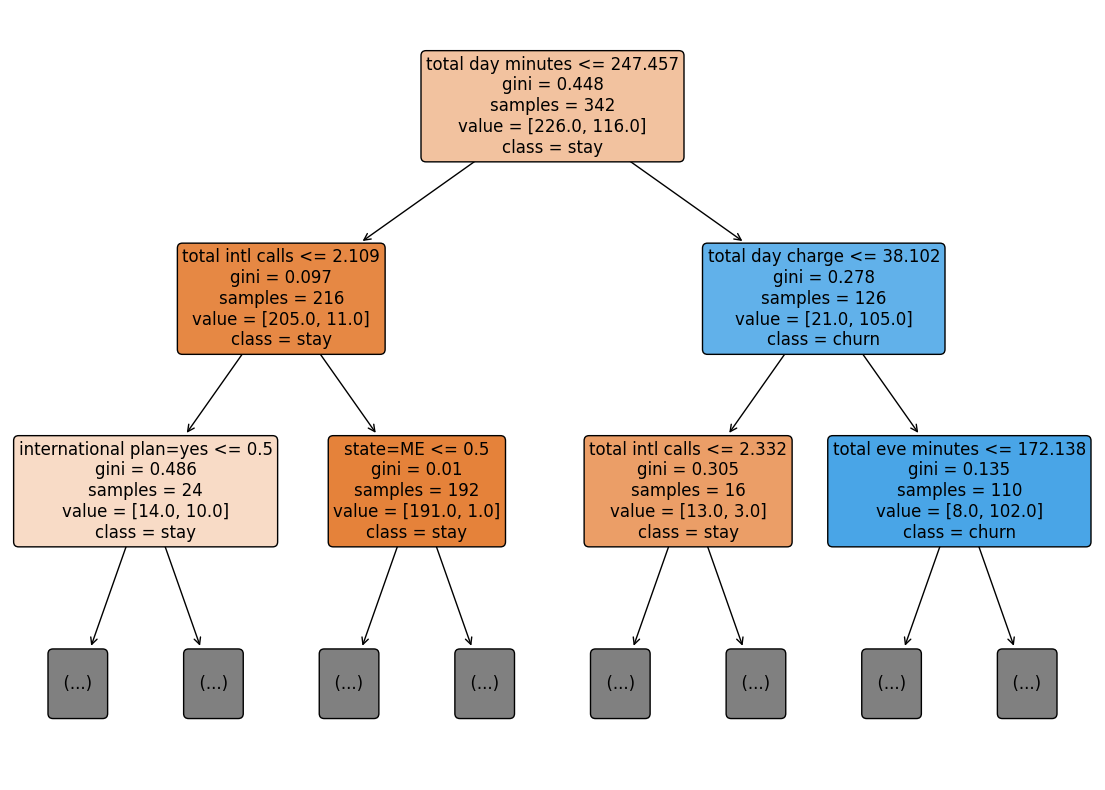

In [38]:
plt.figure(figsize=(14, 10))
plot_tree(exp.dt, 
          feature_names=feature_names, 
          class_names=['stay', 'churn'], 
          filled=True, 
          rounded=True,
          fontsize=12,
          max_depth=2)  
plt.show()

### Counterfactual Explanations

In [59]:
!pip install fat-forensics

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [58]:
import fatf.transparency.predictions.counterfactuals as fatf_cf

ModuleNotFoundError: No module named 'fatf'

In [41]:
# Create a Counterfactual Explainer
cf_explainer = fatf_cf.CounterfactualExplainer(
    model=bb,
    dataset=X_test.astype(float), # cast booleans to float, library dataset has to be of a base type (strings and/or numbers).
    categorical_indices=[],
    default_numerical_step_size=1,
    max_counterfactual_length=1
)

In [42]:
dp_1_cf_tuple = cf_explainer.explain_instance(x1.astype(float))
dp_1_cfs, dp_1_cfs_distances, dp_1_cfs_predictions = dp_1_cf_tuple

In [43]:
dp_1_cfs

array([[ 49.  , 415.  ,   0.  , 266.3 ,  90.  ,  45.27, 170.  , 117.  ,
         17.66, 205.  ,  98.  ,   9.23,  14.  ,   2.  ,   3.78,   2.  ,
          0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
          0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
          0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
          0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
          0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
          0.  ,   0.  ,   0.  ,   0.  ,   1.  ,   0.  ,   0.  ,   0.  ,
          0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   1.  ,   0.  ],
       [ 49.  , 415.  ,   0.  , 266.3 ,  90.  ,  45.27, 170.  , 117.  ,
         17.66, 205.  ,  98.  ,   9.23,  14.  ,   2.  ,   3.78,   0.  ,
          0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
          0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
          0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,

In [44]:
dp_1_cfs_text = fatf_cf.textualise_counterfactuals(
    x1.astype(float),
    dp_1_cfs,
    instance_class=bb_outcome,
    counterfactuals_distances=dp_1_cfs_distances,
    counterfactuals_predictions=dp_1_cfs_predictions)
print(dp_1_cfs_text)

Instance (of class *0*):
[ 49.   415.     0.   266.3   90.    45.27 170.   117.    17.66 205.
  98.     9.23  14.     2.     3.78   2.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   1.     0.     0.     0.     0.     0.     0.     1.     0.     1.
   0.  ]

Feature names: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70]

Counterfactual instance (of class *1*):
Distance: 1.0
    feature *67*: *1.0* -> *0.0*

Counterfactual instance (of class *1*):
Distance: 2.0
    feature *15*: *2.0* -> *0.0*

Counterfactual 

### DALEX

- https://dalex.drwhy.ai/python-dalex-titanic.html
- https://github.com/ModelOriented/DALEX

Sembra interessante, se abbiamo tempo proverei a vederlo